In [2]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
#Pkg.add("OptimizationOptimJL")
include("ng_network.jl")
using Plots, Zygote, LaTeXStrings, BenchmarkTools, Random, Optimization, OptimizationOptimJL, DataInterpolations, SciMLSensitivity

  Activating project at `~/Work/DiffGasNetworks`


In [3]:
# init
dx = 4_000; #m
T = 10 * 3600.0f0; # time [s]

basepath = "../network_specs/israel_reduced/";

net = parse_network_from_files(dx,
    basepath * "network_data/pipes.csv",
    basepath * "network_data/nodes.csv",
    basepath * "initial_conditions/pipe_ic.csv",
    basepath * "initial_conditions/node_ic.csv",
    basepath * "network_data/params_scen1.csv",
    density_from_pressure,
    pressure_from_density);

tspan = (0.0f0, T);
bc_dt = 3600.0;
sys, prob = create_ode_problem!(net, dx, tspan, bc_dt=bc_dt);

In [58]:
# call forward and backward solve once to perform all compilation
sol = solve(prob, SSPRK43(), sensealg=InterpolatingAdjoint())
@time gradient((p)->solve(prob, SSPRK43(), p=p)[end][1], randn(length(parameters(sys))))

 38.339778 seconds (47.62 M allocations: 3.618 GiB, 1.79% gc time)


([0.01414552562779552, 0.014145766025619483, 0.014147160321295952, 0.014147847045158158, 0.014141133088292011, 0.014123117471272003, 0.0141076864832341, 0.014011955948078822, 0.014135242467559024, 0.01395861598117447  …  0.014145619858571771, 0.014145745240633825, 0.014145700227939189, 0.014145001715119256, 0.014143926438184561, 0.014129706300875252, 0.014145468344665221, 0.01414324852721596, 0.014175737384774819, 0.013628910650700307],)

# Initializing Problem Data

In [4]:
abstract type AbstractGenerator end
struct VETurbine <: AbstractGenerator end # Very Efficient
struct METurbine <: AbstractGenerator end # Moderately Efficient
struct IETurbine <: AbstractGenerator end # InEfficient
struct SupplyNode <: AbstractGenerator end

const SM3hr_per_kgs = 5278.486; #(SM^3/hr)/(kg/s)
function kg_to_MW_per_s(kg, g::VETurbine)
    5.5e-3*SM3hr_per_kgs .* max.(0, kg); #MW/(SM3/hr) * (SM3/hr)/(kg/s) * kg = MW/s
end
function kg_to_MW_per_s(kg, g::METurbine)
    5e-3*SM3hr_per_kgs .* max.(0, kg);
end
function kg_to_MW_per_s(kg, g::IETurbine)
    4.5e-3*SM3hr_per_kgs .* max.(0, kg);
end
function kg_to_MW_per_s(kg, g::SupplyNode)
    return 0.0; #don't directly penalize or incentivise supply
end

kg_to_MW_per_s (generic function with 4 methods)

In [92]:
Random.seed!(1);
generator_types = [[VETurbine, METurbine, IETurbine][rand(1:3)]() for i in 1:length(net.vertices)]
generator_types[8] = SupplyNode()
generator_types[1] = SupplyNode()
node_max_fluxes = -[
    0.0,#319964.353462293, 
    401034.56355215+319964.353462293,
    278395.138570498,
    193692.826865002,
    230264.309677921,
    144180.759069048,
    123424.393251773,
    0.0,
    237310.844769435,
    162920.174170613,
    90730.4537580974]/SM3hr_per_kgs;
node_max_fluxes[8] = -sum(node_max_fluxes)
node_max_fluxes[1] = 200.0;

In [93]:
demand_data = [
    7749.80576635134
    7665.06257684148
    7737.77818896848
    7990.7568004049
    8396.91179295888
    8569.81354099665
    8894.89980550278
    8892.28733935892
    9361.57894220448
    9303.11290683391
    9362.85705494176
    9293.59215173005
    9409.64775405078
    9577.08279945256
    9584.44595301904
    9623.02117911938
    9683.73633782682
    9658.75047020743
    9701.9236256501
    9572.39151263986
    9689.61886802519
    9608.05186425859];
demand_times = [(i-1)*(30*60) for i in 1:length(demand_data)]
demand_interpolation = LinearInterpolation(demand_data, demand_times);

# Solving Optimal Gas Flow

In [94]:
dt = get_metadata(net, :dt)
node_ρ_inds = [variable_index(sys, eval(Meta.parse("sys.node_$(i).ρ"))) for i in 1:length(net.vertices)]
num_bc_per_node = get_metadata(net, :num_bc_tsteps);
relu(x) = max(0, x);
pmin, pmax = 60.0*1e5, 80.0*1e5;
pressure_violation_fn(p) = relu.(pmin.-p).^2 + relu.(p.-pmax).^2
saveat = prob.tspan[1]:bc_dt/2:prob.tspan[end]
bc_tsteps = prob.tspan[1]:bc_dt:prob.tspan[end]
demand = [demand_interpolation(t) for t in bc_tsteps];
const α, β, γ = 5e-6, 1e-2, 1e-10;
function loss_fn(p, prob)
    prob = remake(prob, p=p)
    sol = Array(solve(prob, SSPRK43(), dt=dt, adaptive=true, p=p, sensealg=InterpolatingAdjoint(), saveat=saveat, save_end=true))
    gas_cost = sum(relu.(-p))*bc_dt; #kg/s * s
    generated_power = [sum([kg_to_MW_per_s(-p[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][t_num], generator_types[v_num]) for v_num in 1:length(net.vertices)]) for t_num in 1:length(bc_tsteps)-1]
    demand_gap = sum(abs2, [demand[t_num] - generated_power[t_num] for t_num in 1:length(bc_tsteps)-1]/length(bc_tsteps))
    pressure_violation_penalty = sum([sum(pressure_violation_fn(pressure_from_density(sol[node_ρ_inds, t_num]))) for t_num in 2:length(saveat)])/length(saveat);
    return α * gas_cost + β * demand_gap + γ * pressure_violation_penalty;
end

loss_fn (generic function with 1 method)

In [96]:
max_epoch = 100;
losses = zeros(max_epoch)
lr = 1e-3
ps = vcat([[node_max_fluxes[i] for j in 1:num_bc_per_node] for i in 1:length(net.vertices)]...)
ps[1:num_bc_per_node] .= 100.0;
lb = 1.1*ps;
ub = zeros(length(lb));
lb[1:num_bc_per_node] .= 0.0;
ub[1:num_bc_per_node] .= 225.0
lb[7*num_bc_per_node+1:8*num_bc_per_node] .= 0.0;
ub[7*num_bc_per_node+1:8*num_bc_per_node] .= 500;
best_params = zeros(length(ps));

objective(opt_vars, opt_params) = loss_fn(opt_vars, prob)
opt_fn = OptimizationFunction(objective, AutoZygote())
itr_count = 0
function _cb(state, loss_val)
    global itr_count += 1;
    losses[itr_count] = loss_val;
    if ((itr_count > 1) && (loss_val < minimum(losses[1:itr_count-1])))
        best_params .= state.u;
    end
    #if ((state.iter+1) % 50 == 0)
        println("iter = $(itr_count), loss = $(loss_val)");
    #end
    if (itr_count == max_epoch-1)
        print("exit criteria hit")
        return true
    else
        return false
    end
end
opt_prob = OptimizationProblem(opt_fn, ps, nothing, lb=lb, ub=ub)
opt_sol = solve(opt_prob, LBFGS(), maxiters=max_epoch, callback=_cb, x_tol=1e-2, g_tol=1e-3)

iter = 1, loss = 30764.646626251844
iter = 2, loss = 7586.050156067471
iter = 3, loss = 5649.741615155763
iter = 4, loss = 4927.979289509471
iter = 5, loss = 4555.895193772849
iter = 6, loss = 3151.2463340153836
iter = 7, loss = 2001.8612589425907
iter = 8, loss = 1999.4837963720217
iter = 9, loss = 1809.5067374015207
iter = 10, loss = 1542.3100841279168
iter = 11, loss = 1540.2598864651695
iter = 12, loss = 1389.6457676508107
iter = 13, loss = 1309.9615398309913
iter = 14, loss = 1238.8605901658107
iter = 15, loss = 1232.1562899156067
iter = 16, loss = 1090.7864075586642
iter = 17, loss = 1042.8609093150164
iter = 18, loss = 918.1354405422925
iter = 19, loss = 770.0153353742124
iter = 20, loss = 476.35664365684437
iter = 21, loss = 473.51799641637524
iter = 22, loss = 297.9530280537624
iter = 23, loss = 293.09971688080407
iter = 24, loss = 261.28589146024945
iter = 25, loss = 244.7520622972911
iter = 26, loss = 183.12059908195084
iter = 27, loss = 172.53357377727713
iter = 28, loss = 

retcode: Failure
u: 110-element Vector{Float64}:
   14.51201343208788
   14.623921682256464
   15.502096871758205
   17.070191300345456
   19.349630322160092
   22.30516139876607
   26.9258196467023
   33.85059571974332
   43.96087740191778
   64.55228029722537
 -119.69135138386748
 -119.65028379481983
 -125.38672182493656
    ⋮
  -30.172561556688002
  -28.23249718309134
  -11.5675208658656
  -13.508728894714698
  -12.240702760215559
  -13.680679270792565
  -12.669461335744357
  -12.339968527230063
  -13.291638096393456
  -12.213369442327695
  -13.485846507717161
  -13.523084564790778

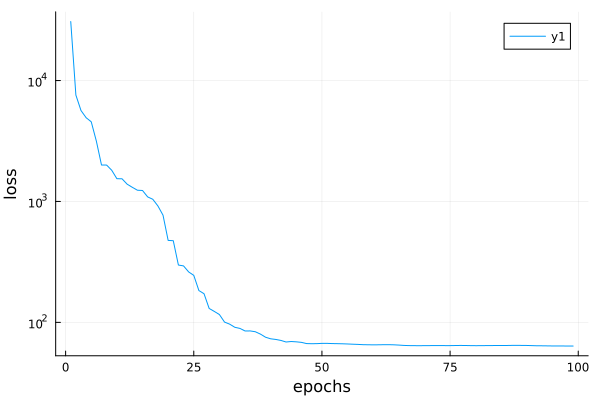

In [97]:
plot(losses[findall(x->x!=0.0, losses)], ylabel="loss", xlabel="epochs", yaxis=:log)

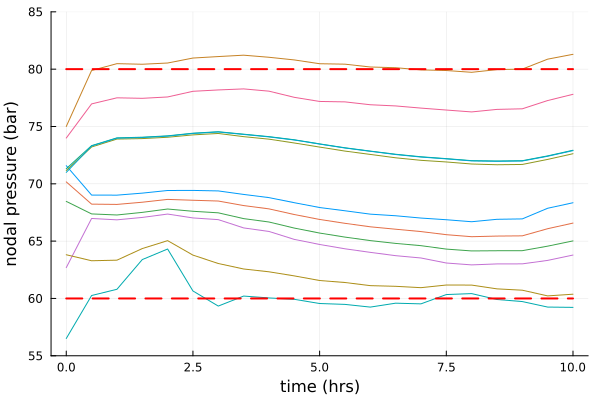

In [103]:
sol = solve(prob, SSPRK43(), p=best_params, dt=dt, saveat=saveat)
sol_arr = Array(sol)
p = plot()
for i in 1:length(net.vertices)
    plot!(p, sol.t/3600, pressure_from_density.(sol_arr[node_ρ_inds[i], :])/1e5, label="node $(i) pressure")
end
plot!(p, legend=false, xlabel="time (hrs)", ylabel="nodal pressure (bar)", ylims=(55,85))
plot!(p, sol.t/3600, [pmin/1e5 for i in sol.t], linestyle=:dash, linecolor=:red, linewidth=2, label=nothing)
plot!(p, sol.t/3600, [pmax/1e5 for i in sol.t], linestyle=:dash, linecolor=:red, linewidth=2, label="pressure limits")

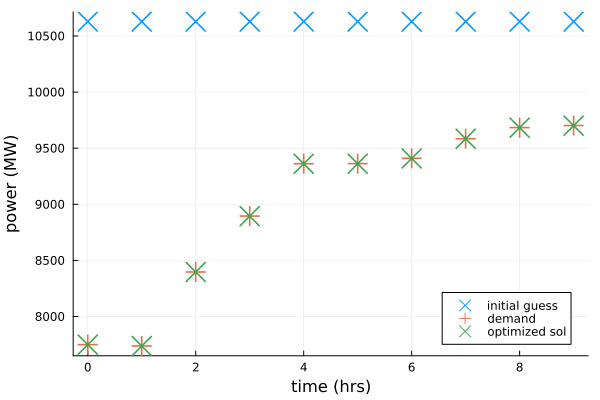

In [99]:
function generated_power(_params, ind)
    sum([kg_to_MW_per_s(-_params[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][ind], 
                generator_types[v_num]) 
            for v_num in 1:length(net.vertices)])
end
times = bc_tsteps[1:end-1]/3600;
scatter(times, [generated_power(ps,i) for i in 1:length(bc_tsteps)-1], label="initial guess", markershape=:x, markersize=10, markerstrokewidth=2)
scatter!(times, demand, label="demand", markershape=:+, markersize=10, markerstrokewidth=2)
scatter!(times, [generated_power(best_params,i) for i in 1:length(bc_tsteps)-1], label="optimized sol", markershape=:x, markersize=10, markerstrokewidth=2)
plot!(ylabel="power (MW)", xlabel="time (hrs)", legend=:bottomright)

# Solving Optimal Gas Flow Under Uncertainty

In [116]:
prob = remake(prob, p=randn(length(parameters(sys))))
prob.p

110-element Vector{Float64}:
 -0.6169530074798337
 -0.3305147445675949
 -1.1748086016954915
 -0.26036727268260235
  1.801744078332295
 -0.3415511736480165
  0.6847652411569006
  0.11451406887252362
 -0.5304758115937055
 -2.2526000778274726
  0.4421845130612445
 -0.39691783768688543
  0.2602127847647602
  ⋮
  0.9375790409483377
 -1.3012022555855323
  0.15787061691837181
  0.18803245521833706
  0.4237647957650894
  0.9428752967610503
  1.5038277010458687
  0.49730237773085095
 -1.7029390629526842
  0.04169275015983895
  1.417298263586682
 -0.26456007640950324

In [117]:
function remake_prob(prob, i, repeat)
    @. prob.p += randn()*prob.p
    return prob
end
eprob = EnsembleProblem(prob, prob_func=remake_prob);
sols = solve(eprob, SSPRK43(), trajectories=10, dt=dt, adaptive=true, sensealg=InterpolatingAdjoint(), saveat=saveat, save_end=true)

EnsembleSolution Solution of length 10 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.Fu

In [120]:
sols[1].prob.p

110-element Vector{Float64}:
 -0.19561355327278568
 -0.2441342373744525
  1.6353419795409454
  0.12107000817171626
  1.2249612835402908
 -0.151459811097359
  1.6886400631401641
  0.01827685056146086
 -0.3868461823295548
 -2.3755714120612064
  1.165085885550185
 -0.8193042326218303
  0.15633091404737784
  ⋮
  0.46168984671849816
  0.3427498600861971
 -0.16687061572810882
  0.33163906432220924
 -0.045823287026015125
  1.7870332296453264
  0.09767737454989334
 -0.2907851015928562
  1.9769722686673048
 -0.0010807059422778473
  3.456666544382925
 -0.2448526093985132

In [148]:
prob = remake(prob, p=randn(length(parameters(sys)))) #just to convert ps to non MTK params
length(randn(length(prob.p)))
length(solve(prob, SSPRK43()))

23555

In [255]:
1 in node_1_param_inds

true

In [257]:
node_1_param_inds = 1:num_bc_per_node
node_8_param_inds = 7*num_bc_per_node+1:8*num_bc_per_node
function remake_prob(prob, i, repeat)
    prob.p .+= 0.05*randn()*[(i in node_1_param_inds || i in node_8_param_inds) ? 0.0 : prob.p[i] for i in 1:length(prob.p)]
    return prob
end
function ensemble_loss_fn(p, prob, trajs=10)
    prob = remake(prob, p=p)
    eprob = EnsembleProblem(prob, prob_func=remake_prob);
    sols = solve(eprob, SSPRK43(), EnsembleThreads(), trajectories=trajs, dt=dt, adaptive=true, sensealg=InterpolatingAdjoint(), saveat=saveat, save_end=true)
    loss = 0.0;
    for i in 1:trajs
        gas_cost = sum(relu.(-sols[i].prob.p))*bc_dt; #kg/s * s
        generated_power = [sum([kg_to_MW_per_s(-sols[i].prob.p[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][t_num], generator_types[v_num]) for v_num in 1:length(net.vertices)]) for t_num in 1:length(bc_tsteps)-1]
        demand_gap = sum(abs2, [demand[t_num] - generated_power[t_num] for t_num in 1:length(bc_tsteps)-1]/length(bc_tsteps))
        pressure_violation_penalty = sum([sum(pressure_violation_fn(pressure_from_density(sols[i][t_num][node_ρ_inds]))) for t_num in 2:length(saveat)])/length(saveat);
        loss += α * gas_cost + β * demand_gap + γ * pressure_violation_penalty;
    end
    return loss/trajs
end
@time ensemble_loss_fn(opt_sol.u, prob)
#@time gradient((p)->ensemble_loss_fn(p, prob), opt_sol.u)

  1.364218 seconds (3.38 M allocations: 209.025 MiB, 9.32% gc time)


720.9502956448127

In [265]:
itr_count = 0
max_iters = 100
best_params = zeros(length(prob.p));
losses = zeros(max_iters)
function cb(state, loss_val)
    global itr_count += 1;
    losses[itr_count] = loss_val;
    if ((itr_count > 1) && (loss_val < minimum(losses[1:itr_count-1])))
        best_params .= state.u;
    end
    #if ((state.iter+1) % 50 == 0)
        println("iter = $(itr_count), loss = $(loss_val)");
    #end
    if (itr_count == max_iters-1)
        print("exit criteria hit")
        return true
    else
        return false
    end
end
opt_eprob = OptimizationProblem((p,u)->ensemble_loss_fn(p, prob, 5), opt_sol.u, nothing)
opt_esol = solve(opt_eprob, NelderMead(parameters = Optim.AdaptiveParameters(α = 1.0, β = 1.05, γ = 0.75, δ = 0.75)), callback=cb, maxiters=max_iters)


iter = 1, loss = 1367.0386462277831
iter = 2, loss = 3594.414872617461
iter = 3, loss = 3271.4425679342908
iter = 4, loss = 4606.567816326853
iter = 5, loss = 3945.6284232062208
iter = 6, loss = 2007.5156494331393
iter = 7, loss = 3567.7817295066648
iter = 8, loss = 4241.551427449316
iter = 9, loss = 3358.881394950336
iter = 10, loss = 2662.2065292599955
iter = 11, loss = 3106.140560842903
iter = 12, loss = 2664.241886548515
iter = 13, loss = 3925.195082099225
iter = 14, loss = 2937.374397520507
iter = 15, loss = 2800.244737632037
iter = 16, loss = 2293.5357999689736
iter = 17, loss = 409.98296054028407
iter = 18, loss = 1503.9956478419215
iter = 19, loss = 523.5517362040713
iter = 20, loss = 2621.0274999524254
iter = 21, loss = 2315.8240794106273
iter = 22, loss = 2354.6967859248016
iter = 23, loss = 594.6578130826246
iter = 24, loss = 527.5272320570978
iter = 25, loss = 727.6591702524735
iter = 26, loss = 2524.7811208553267
iter = 27, loss = 1067.7057064996218
iter = 28, loss = 1777.

LoadError: InterruptException:

In [262]:
prob = remake(prob, p=best_params);
eprob = EnsembleProblem(prob, prob_func=remake_prob);
sols = solve(eprob, SSPRK43(), trajectories=15, saveat=bc_tsteps);

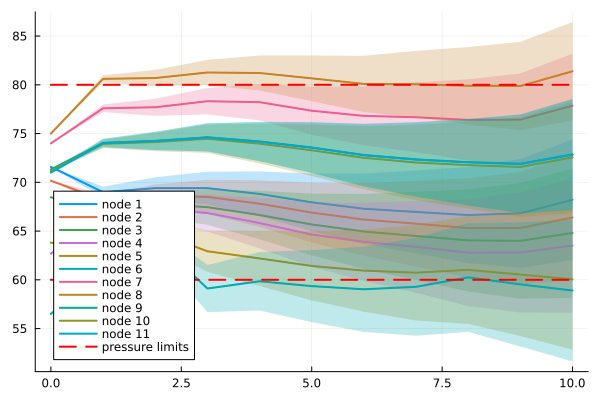

In [264]:
p = plot()
ts = sols[1].t/3600
for i in 1:length(net.vertices)#[1, 4, 6, 8, 11]
    node_pressures = pressure_from_density.(hcat([[sols[e_num][t_num][node_ρ_inds[i]] for t_num in 1:length(sols[i].t)] for e_num in 1:length(sols)]...))/1e5
    m = mean(node_pressures, dims=2)
    σ = std(node_pressures, dims=2)
    plot!(p, ts, m, ribbon=(σ), color=i, fillalpha=0.25, label=nothing)
    plot!(p, ts, m, color=i, linewidth=2, label="node $(i)")
end
plot!(p, ts, [pmin/1e5 for i in ts], linestyle=:dash, linecolor=:red, linewidth=2, label=nothing)
plot!(p, ts, [pmax/1e5 for i in ts], linestyle=:dash, linecolor=:red, linewidth=2, label="pressure limits")
p

# Multi-Fidelity Optimization

In [275]:
hyper_params = [#(dx, bc_dt)
    (4_000, 7200.0),
    (4_000, 3600.0),
    (2_000, 1800.0),
    (1_000, 1800.0)]
models = Dict();
model_num = 1;
for (dx, bc_dt) in hyper_params
    T = 10 * 3600.0f0; # time [s]
    
    basepath = "../network_specs/israel_reduced/";
    
    net = parse_network_from_files(dx,
        basepath * "network_data/pipes.csv",
        basepath * "network_data/nodes.csv",
        basepath * "initial_conditions/pipe_ic.csv",
        basepath * "initial_conditions/node_ic.csv",
        basepath * "network_data/params_scen1.csv",
        density_from_pressure,
        pressure_from_density);

    tspan = (0.0f0, T);
    bc_dt = 3600.0;
    sys, prob = create_ode_problem!(net, dx, tspan, bc_dt=bc_dt);
    prob = remake(prob, p=zeros(length(parameters(sys))))
    push!(models, model_num=>Dict(:net=>net, :sys=>sys, :prob=>prob, :dx=>dx, :bc_dt=>bc_dt))

    # compile the models
    sol = solve(prob, SSPRK43(), sensealg=InterpolatingAdjoint())
    @time gradient((p)->solve(prob, SSPRK43(), p=p)[end][1], randn(length(parameters(sys)))) 
    model_num += 1
end
models

Dict{Any, Any} with 4 entries:
  4 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>1000, :prob=>ODEProblem{Vector{Fl…
  2 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>4000, :prob=>ODEProblem{Vector{Fl…
  3 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>2000, :prob=>ODEProblem{Vector{Fl…
  1 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>4000, :prob=>ODEProblem{Vector{Fl…

In [281]:
function initialize_next_model_params_with_lower_fidelity_params!(hf_model, lf_model, lf_best_params)
    lf_bc_dt = lf_model[:bc_dt];
    hf_bc_dt = hf_model[:bc_dt];
    repeat_num = Int(hf_bc_dt/lf_bc_dt)

    @assert length(hf_model[:prob].p) == repeat_num*length(lf_model[:prob].p)
    @assert length(lf_best_params) == length(lf_model[:prob].p)
    hf_model[:prob] = remake(hf_model[:prob], p=vcat([[lf_model[:prob].p[i] for j in 1:repeat_num] for i in 1:length(lf_model[:prob].p)]...))
end
# initialize_next_model_params_with_lower_fidelity_params!(models[2], models[1], zeros(length(models[1][:prob].p)))
# models[2][:prob].p

110-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [284]:
epochs_per_fidelity = 50;
total_epochs = model_num*epochs_per_fidelity;
losses = zeros(total_epochs)

#setup initial guess
num_bc_per_node = get_metadata(models[1][:net], :num_bc_tsteps);
ps = vcat([[node_max_fluxes[i] for j in 1:num_bc_per_node] for i in 1:length(net.vertices)]...)
ps[1:num_bc_per_node] .= 100.0;
models[1][:prob] = remake(models[1][:prob], p=ps)

#setup lowest fidelity optimization bounds
lf_lb = 1.1*ps;
lf_ub = zeros(length(lf_lb));
lf_lb[1:num_bc_per_node] .= 0.0;
lf_ub[1:num_bc_per_node] .= 225.0
lf_lb[7*num_bc_per_node+1:8*num_bc_per_node] .= 0.0;
lf_ub[7*num_bc_per_node+1:8*num_bc_per_node] .= 500;

objective(opt_vars, opt_params) = loss_fn(opt_vars, prob)
opt_fn = OptimizationFunction(objective, AutoZygote())
itr_count = 0
for i in 1:model_num
    if (i > 1) 
        #re-size optimization bounding box
        repeat_num = Int(models[i][:bc_dt]/models[1][:bc_dt])
        _lb = vcat([[lf_lb[i] for j in 1:num_bc_per_node] for i in 1:length(models[1][:net].vertices)]...)
        _ub = vcat([[lf_ub[i] for j in 1:num_bc_per_node] for i in 1:length(models[1][:net].vertices)]...)

        #initialize params to best sol from last level
        initialize_next_model_params_with_lower_fidelity_params!(models[i], models[i-1], models[i-1][:opt_sol].u)
    end
    prob,sys,net = models[i][:prob], models[i][:sys], models[i][:net];
    best_params = zeros(length(ps));


    function _cb(state, loss_val)
        global itr_count += 1;
        losses[itr_count] = loss_val;
        if ((itr_count > 1) && (loss_val < minimum(losses[1:itr_count-1])))
            best_params .= state.u;
        end
        #if ((state.iter+1) % 50 == 0)
            println("iter = $(itr_count), loss = $(loss_val)");
        #end
        if (itr_count == epochs_per_fidelity*i-1)
            println("exit criteria hit")
            return true
        else
            return false
        end
    end
    opt_prob = OptimizationProblem(opt_fn, prob.p, nothing, lb=lb, ub=ub)
    opt_sol = solve(opt_prob, LBFGS(), maxiters=epochs_per_fidelity, callback=_cb, x_tol=1e-2, g_tol=1e-3)
    push!(models[i], :opt_sol=>opt_sol)
end

iter = 1, loss = 30764.646626251844
iter = 2, loss = 7586.113583094801
iter = 3, loss = 5649.62731980022
iter = 4, loss = 4927.738440943458
iter = 5, loss = 4555.676252583187
iter = 6, loss = 3151.7298090442946
iter = 7, loss = 1920.6794208071901
iter = 8, loss = 1844.8647266393587
iter = 9, loss = 1499.1885535787087
exit criteria hititer = 10, loss = 30764.646626251844
iter = 11, loss = 7586.113583094801
iter = 12, loss = 5649.62731980022
iter = 13, loss = 4927.738440943458
iter = 14, loss = 4555.676252583187
iter = 15, loss = 3151.7298090442946
iter = 16, loss = 1920.6794208071901
iter = 17, loss = 1844.8647266393587
iter = 18, loss = 1499.1885535787087
iter = 19, loss = 1381.5633516848402
exit criteria hititer = 20, loss = 30765.51756394384
iter = 21, loss = 7753.1386202606
iter = 22, loss = 5814.146491437705
iter = 23, loss = 5044.777673701126
iter = 24, loss = 4668.64306563808
iter = 25, loss = 3361.3040628522344
iter = 26, loss = 2382.9500275548803
iter = 27, loss = 2106.50889108

┌ Warning: Potential performance improvement omitted. EnzymeVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/rXkM4/src/concrete_solve.jl:26
┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/rXkM4/src/concrete_solve.jl:69
┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/RHbdj/src/integrator_interface.jl:626
┌ Warning: Automatic AD choice of autojacvec failed in ODE adjoint, failing back to ODE adjoint + numerical vjp
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensi

LoadError: InterruptException:

# Benchmarks

In [31]:
@benchmark solve(prob, SSPRK43(), p=params, sensealg=InterpolatingAdjoint())

BenchmarkTools.Trial: 319 samples with 1 evaluation.
 Range (min … max):  11.740 ms … 25.580 ms  ┊ GC (min … max):  0.00% … 46.88%
 Time  (median):     13.288 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   15.693 ms ±  4.186 ms  ┊ GC (mean ± σ):  16.68% ± 19.00%

        ▅█                                                     
  ▃▃▂▃▃▅██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▃▃▂▂▃▃▃▂▃▃▃▃▂▃▂▂▂ ▂
  11.7 ms         Histogram: frequency by time        24.3 ms <

 Memory estimate: 33.60 MiB, allocs estimate: 20158.

In [32]:
@benchmark gradient(loss, params)

BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  204.606 ms … 224.408 ms  ┊ GC (min … max): 0.00% … 6.68%
 Time  (median):     217.938 ms               ┊ GC (median):    6.66%
 Time  (mean ± σ):   217.091 ms ±   4.836 ms  ┊ GC (mean ± σ):  5.77% ± 2.04%

  ▁▁                         ▁▁▁ █▁   ▁█  ▁█▁▁▁▁     █▁   █   ▁  
  ██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▁██▁▁▁██▁▁██████▁▁▁▁▁██▁▁▁█▁▁▁█ ▁
  205 ms           Histogram: frequency by time          224 ms <

 Memory estimate: 126.52 MiB, allocs estimate: 560278.